## greedy search #1

32.25578487033703 ['white']
30.028550906398593 ['white', 'black']
26.973532454501736 ['green', 'white', 'black']
26.720868607963702 ['green', 'white', 'white', 'black']
17.662378222434835 ['blue', 'green', 'white', 'white', 'black']
15.779956089303504 ['green', 'blue', 'green', 'white', 'white', 'black']
11.593719224276098 ['blue', 'green', 'blue', 'green', 'white', 'white', 'black']
10.307297453647033 ['green', 'blue', 'green', 'blue', 'green', 'white', 'white', 'black']
8.699044633684641 ['blue', 'green', 'blue', 'green', 'blue', 'green', 'white', 'white', 'black']
7.703112648609881 ['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'white', 'white', 'black']


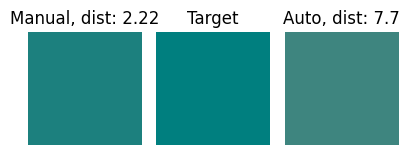

['blue', 'blue', 'blue', 'green', 'green']


C:\Users\Matyanson\AppData\Local\Temp\ipykernel_22848\1466043471.py:99: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(
C:\Users\Matyanson\AppData\Local\Temp\ipykernel_22848\1466043471.py:114: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


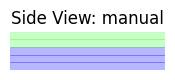

['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'white', 'white', 'black']


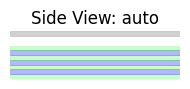

In [41]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

# GLOBAL
filaments = {
    'black': {
        'rgb': [0.0, 0.0, 0.0],
        'td': 0.5,   # Transmission Distance in mm
    },
    'blue': {
        'rgb': [0.0, 0.0, 1.0],
        'td': 0.3,
    },
    'green': {
        'rgb': [0.0, 1.0, 0.0],
        'td': 0.4,
    },
    'red': {
        'rgb': [1.0, 0.0, 0.0],
        'td': 0.2,
    },
    'white': {
        'rgb': [1.0, 1.0, 1.0],
        'td': 0.7,
    },
}

layer_thickness = 0.1  # mm per layer
base_color = [0.5, 0.5, 0.5]  # white background
target_color = [0.0, 0.5, 0.5]  # custom teal



def alpha_from_td(thickness, td):
    """
    Convert thickness (mm) and transmission distance (mm) to an opacity:
      alpha = 1 - exp(-thickness / td)
    """
    return 1 - np.exp(-thickness / td)

def composite_over(base_rgb, top_rgb, top_alpha):
    return top_alpha * top_rgb + (1 - top_alpha) * base_rgb

def color_distance(rgb1, rgb2):
    """
    Compute perceptual distance between two RGB colors using Delta E (CIE76).
    
    Args:
        rgb1, rgb2: Tuples or lists of 3 floats (R, G, B), range 0..1

    Returns:
        Distance (float) between colors
    """
    # Convert RGB to LAB
    rgb1 = np.array(rgb1).reshape(1, 1, 3)
    rgb2 = np.array(rgb2).reshape(1, 1, 3)
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)

    # Euclidean distance in LAB space
    return np.linalg.norm(lab1 - lab2)

# 6) Blend layer by layer using TD-based alpha
def blend_layers(layers):
    current_rgb = np.array(base_color, dtype=float)
    for i, name in enumerate(layers, start=1):
        rgb = np.array(filaments[name]['rgb'], dtype=float)
        td = filaments[name]['td']
        alpha = alpha_from_td(layer_thickness, td)
        current_rgb = composite_over(current_rgb, rgb, alpha)

    return current_rgb

# 7) Show a side-by-side comparison of blended vs. target
def print_comparasion(target, color1, color2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 2))
    ax1.imshow(np.ones((10,10,3)) * color1.reshape((1,1,3)))
    ax1.set_title(f"Manual, dist: {round(color_distance(color1, target), 2)}")
    ax2.imshow(np.ones((10,10,3)) * np.array(target).reshape((1,1,3)))
    ax2.set_title("Target")
    ax3.imshow(np.ones((10,10,3)) * color2.reshape((1,1,3)))
    ax3.set_title(f"Auto, dist: {round(color_distance(color2, target), 2)}")
    for ax in (ax1, ax2, ax3):
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 8) Visualize each layer from the side with uniform thickness
def visualize_stack(stack, title):
    print(stack)
    total_thickness = layer_thickness * len(stack)
    fig2, ax2 = plt.subplots(figsize=(2, total_thickness))
    y_bottom = 0
    for i, name in enumerate(stack, start=1):
        rgb = filaments[name]['rgb']
        td = filaments[name]['td']
        alpha = alpha_from_td(layer_thickness, td)
        rect = plt.Rectangle(
            (0, y_bottom), 1, layer_thickness,
            color=(rgb[0], rgb[1], rgb[2], alpha),
            edgecolor='black',
            linewidth=0.5
        )
        ax2.add_patch(rect)
        y_bottom += layer_thickness

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, total_thickness)
    ax2.set_aspect('auto')
    ax2.axis('off')
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


def get_stack(max_layers):
    best_stack = []
    best_distance = 10000

    for i in range(max_layers):
        local_best_distance = 10000
        local_best_stack = []
        for f_name, f in filaments.items():
            dist, new_stack = insert_into_stack(best_stack, f_name)

            if(dist < best_distance):
                local_best_distance = dist
                local_best_stack = new_stack
        
        # no possible improvement
        if(local_best_distance == 10000): break
        
        if(local_best_distance < best_distance):
            best_distance = local_best_distance
            best_stack = local_best_stack
            print(best_distance, best_stack)
    
    return best_stack


def insert_into_stack(stack, new_f_name):
    best_dist = 10000
    best_perm = np.array(stack, dtype=str)

    # try all new permutations with the new fillament
    for i in range(len(stack) + 1):
        stack_copy = list(stack)
        stack_copy.insert(i, new_f_name)

        blend_rgb = blend_layers(stack_copy)
        dist = color_distance(target_color, blend_rgb)
        
        if(dist < best_dist):
            best_dist = dist
            best_perm = stack_copy
    
    return [best_dist, best_perm]






# --- DO STUFF ---
stack_manual = ['blue'] * 3 + ['green'] * 2
stack_auto = get_stack(10)

blended_manual = blend_layers(stack_manual)
blended_auto = blend_layers(stack_auto)

print_comparasion(target_color, blended_manual, blended_auto)

visualize_stack(stack_manual, "Side View: manual")
visualize_stack(stack_auto, "Side View: auto")

## greedy serch (refactor)

{'black': {'rgb': [0.0, 0.0, 0.0], 'alpha': np.float64(0.18126924692201818)}, 'blue': {'rgb': [0.0, 0.0, 1.0], 'alpha': np.float64(0.28346868942621073)}, 'green': {'rgb': [0.0, 1.0, 0.0], 'alpha': np.float64(0.22119921692859512)}, 'red': {'rgb': [1.0, 0.0, 0.0], 'alpha': np.float64(0.3934693402873666)}, 'white': {'rgb': [1.0, 1.0, 1.0], 'alpha': np.float64(0.1331221002498184)}}


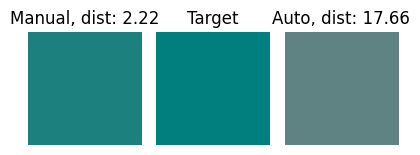

['blue', 'blue', 'blue', 'green', 'green']


C:\Users\Matyanson\AppData\Local\Temp\ipykernel_14548\527525820.py:118: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle(
C:\Users\Matyanson\AppData\Local\Temp\ipykernel_14548\527525820.py:133: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


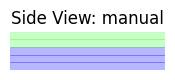

['blue', 'green', 'white', 'white', 'black']


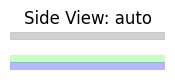

In [2]:
import numpy as np
from skimage import color
import matplotlib.pyplot as plt

# --- UTILITY FUNCTIONS ---
def rgb_to_lab(rgb):
    rgb = np.array(rgb).reshape(1, 1, 3)
    lab = color.rgb2lab(rgb)
    return lab[0, 0]

def lab_to_rgb(lab):
    lab = np.array(lab).reshape(1, 1, 3)
    rgb = color.lab2rgb(lab)
    return rgb[0, 0]

def alpha_from_td(thickness, td):
    """
    Convert thickness (mm) and transmission distance (mm) to an opacity:
      alpha = 1 - exp(-thickness / td)
    """
    return 1 - np.exp(-thickness / td)

def composite_over(base_rgb, top_rgb, top_alpha):
    return top_alpha * top_rgb + (1 - top_alpha) * base_rgb

def color_distance(rgb1, rgb2):
    rgb1 = np.array(rgb1).reshape(1, 1, 3)
    rgb2 = np.array(rgb2).reshape(1, 1, 3)
    lab1 = color.rgb2lab(rgb1)
    lab2 = color.rgb2lab(rgb2)

    # Euclidean distance in LAB space
    return np.linalg.norm(lab1 - lab2)


# --- GLOBAL ---
filaments = {
    'black': {
        'rgb': [0.0, 0.0, 0.0],
        'td': 0.5,   # Transmission Distance in mm
    },
    'blue': {
        'rgb': [0.0, 0.0, 1.0],
        'td': 0.3,
    },
    'green': {
        'rgb': [0.0, 1.0, 0.0],
        'td': 0.4,
    },
    'red': {
        'rgb': [1.0, 0.0, 0.0],
        'td': 0.2,
    },
    'white': {
        'rgb': [1.0, 1.0, 1.0],
        'td': 0.7,
    },
}

layer_thickness = 0.1  # mm per layer
base_color = [0.5, 0.5, 0.5]  # white background
target_color = [0.0, 0.5, 0.5]  # custom teal


# --- SETUP ---
colors = {} # {"rgb", "alpha"}
for f_name, f in filaments.items():
    rgb = f['rgb']
    td = f['td']
    alpha = alpha_from_td(layer_thickness, td)
    colors[f_name] = {
        "rgb": rgb,
        "alpha": alpha
    }

print(colors)


# 6) Blend layer by layer using TD-based alpha
def blend_layers(layers):
    current_rgb = np.array(base_color, dtype=float)
    for i, name in enumerate(layers, start=1):
        rgb = np.array(colors[name]['rgb'], dtype=float)
        alpha = colors[name]['alpha']
        current_rgb = composite_over(current_rgb, rgb, alpha)

    return current_rgb

# 7) Show a side-by-side comparison of blended vs. target
def print_comparasion(rgb1, rgb2):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(4, 2))
    dist1 = round(color_distance(rgb1, target_color), 2)
    ax1.imshow(np.ones((10,10,3)) * rgb1.reshape((1,1,3)))
    ax1.set_title(f"Manual, dist: {dist1}")

    ax2.imshow(np.ones((10,10,3)) * np.array(target_color).reshape((1,1,3)))
    ax2.set_title("Target")
    
    dist2 = round(color_distance(rgb2, target_color), 2)
    ax3.imshow(np.ones((10,10,3)) * rgb2.reshape((1,1,3)))
    ax3.set_title(f"Auto, dist: {dist2}")

    for ax in (ax1, ax2, ax3):
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 8) Visualize each layer from the side with uniform thickness
def visualize_stack(stack, title):
    print(stack)
    total_thickness = layer_thickness * len(stack)
    fig2, ax2 = plt.subplots(figsize=(2, total_thickness))
    y_bottom = 0
    for i, name in enumerate(stack, start=1):
        rgb = colors[name]['rgb']
        alpha = colors[name]['alpha']
        rect = plt.Rectangle(
            (0, y_bottom), 1, layer_thickness,
            color=(rgb[0], rgb[1], rgb[2], alpha),
            edgecolor='black',
            linewidth=0.5
        )
        ax2.add_patch(rect)
        y_bottom += layer_thickness

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, total_thickness)
    ax2.set_aspect('auto')
    ax2.axis('off')
    ax2.set_title(title)

    plt.tight_layout()
    plt.show()


def get_stack(max_layers):
    best_stack = []
    best_distance = 10000

    for i in range(max_layers):
        local_best_distance = 10000
        local_best_stack = []
        for c_name, c in colors.items():
            dist, new_stack = insert_into_stack(best_stack, c_name)

            if(dist < best_distance):
                local_best_distance = dist
                local_best_stack = new_stack
        
        # no possible improvement
        if(local_best_distance == 10000): break
        
        if(local_best_distance < best_distance):
            best_distance = local_best_distance
            best_stack = local_best_stack
    
    return best_stack


def insert_into_stack(stack, new_c_name):
    best_dist = 10000
    best_perm = np.array(stack, dtype=str)

    # try all new permutations with the new fillament
    for i in range(len(stack) + 1):
        stack_copy = list(stack)
        stack_copy.insert(i, new_c_name)

        blend = blend_layers(stack_copy)
        dist = color_distance(target_color, blend)
        
        if(dist < best_dist):
            best_dist = dist
            best_perm = stack_copy
    
    return [best_dist, best_perm]




# --- DO STUFF ---

stack_manual = ['blue'] * 3 + ['green'] * 2
stack_auto = get_stack(5)

blended_manual = blend_layers(stack_manual)
blended_auto = blend_layers(stack_auto)

print_comparasion(blended_manual, blended_auto)

visualize_stack(stack_manual, "Side View: manual")
visualize_stack(stack_auto, "Side View: auto")